# Ultimate Technologies Inc. Take-Home Challenge

# Table of Contents<a id='#wrangle'></a>
* [0.0 Ultimate Tech](#1_______)
  * [0.1 Imports & Set Up](#imports)
  * [0.2 Content](#content)
* [1.0 Exploratory data analysis (EDA)](#p_one)
  * [1.1 Data Extraction](#1data_ex)
  * [1.2 Date Aggregation](#1data_e)
  * [1.3 Macro](#macro)
  * [1.4 Sub-Macro](#s_macro)
  * [1.5 Micro](#micro)
  * [1.6 Overall Summary](#o_sum)
* [2.0 Experiment and metrics design](#p_two)
  * [2.1 Criteria for success](#success_c)
  * [2.2 Practical Experiment](#experiment)
* [3.0 Predictive modeling](#p_three)
  * [3.1 Cleaning](#p_three_clean)
  * [3.2 EDA](#p_three_eda)
  * [3.3 Modeling](#p_three_model)
  * [3.4 Summary](#p_three_summary)


**Imports & Setup**<a id='imports'></a>

In [312]:
import re
import string
import requests
import os
import sys
import statistics
from scipy.stats import skew
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
%matplotlib inline
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import datetime
import time
import warnings
warnings.filterwarnings("ignore")
%reload_ext watermark


**Content**<a id='content'></a>

**The Goal ("Goal")** of this section is too:
   * **Best characterize the underlying patterns of the demand**

# Part 1 ‑ Exploratory data analysis<a id='p_one'></a>

**Data Extraction**<a id='1data_ex'></a>

In [313]:
cd

C:\Users\rands


In [314]:
df_logins = pd.read_json('./SB #26 Effective Interviewing for Data Scientists/Ultimate Technologies Inc. Take-Home Challenge/logins.json')

**Date Aggregation** | Here we will aggregate the login counts based on 15 minute time intervals.<a id='1data_e'></a>

In [315]:
# taking a quick look at what we have
df_logins.head(3)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37


In [316]:
# setting up the infastructure to see how many logins were done in the 15min intervals throught the day
df_logins['count'] = 1
df_logins.set_index('login_time', inplace=True)
df_logins = df_logins.resample('15Min',  loffset='15Min00s').sum()
df_logins = df_logins.reset_index()

In [317]:
df_min_time = df_logins['login_time'].min()
df_max_time = df_logins['login_time'].max()
mnth_dif = df_max_time.month - df_min_time.month
total_login = df_logins['count'].sum()

print(' We have a dataframe between:','\n','\n',df_min_time,'\n',df_max_time,'\n','\n',
     'So approx.',mnth_dif,'months in',df_logins['login_time'][0].year,'\n','\n',
      'With','{:,.0f}'.format(total_login),'total logins recorded'
     )

 We have a dataframe between: 
 
 1970-01-01 20:15:00 
 1970-04-13 19:00:00 
 
 So approx. 3 months in 1970 
 
 With 93,142 total logins recorded


<a id='macro'></a> **Macro** | We will start on a macro level & move to micro; to begin:
   * Let's look at the change over the course of these 3 months

(0.0, 80.0)

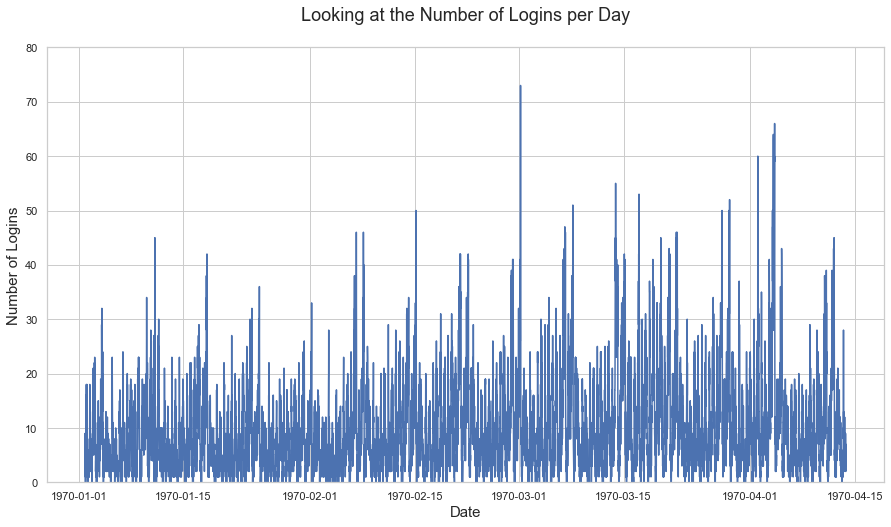

In [318]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(15,8))
ax = sns.lineplot(data=df_logins, x="login_time", y="count")
# ax.set(xlabel='Number of Logins ', ylabel='Date')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of Logins', fontsize=15)
plt.title('Looking at the Number of Logins per Day\n', fontsize=18)
plt.ylim(0,80)

**Macro Summary** | **No clear resolution to our Goal** albeit it "may" be relevant to mention that it visually appears to have an uptrend which may have been broken in April. We believe this may fall outside the scope of this project & thus will set it aside for now.

<a id='s_macro'></a>**Sub-Macro** | There visually appears to be **a "cyclical" nature ("Rhythm") to the logins at the Macro-level**. The rhythm does not look to be a monthly rhythm; **the rhythm may be a weekly beat so we will investigate this.**

In [319]:
df_logins_wk = df_logins.copy()
df_logins_wk['wkday'] = df_logins_wk['login_time'].dt.dayofweek
df_logins_wk.head(3)

,login_time,count,wkday
0,1970-01-01 20:15:00,2,3
1,1970-01-01 20:30:00,6,3
2,1970-01-01 20:45:00,9,3


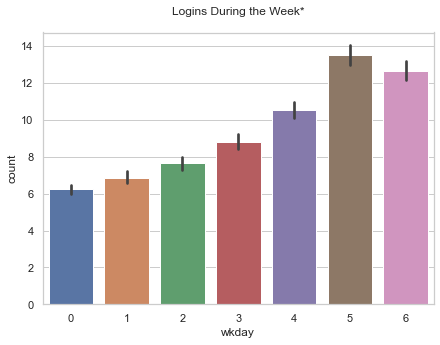

In [320]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(7,5))

sns.barplot(x="wkday", y="count", data=df_logins_wk)
a.set(title='Logins During the Week*')
a.set(xlabel='Weekday', ylabel='Total Number of Logins')
plt.title('Logins During the Week*\n', fontsize=12)

plt.show()

<Figure size 1440x720 with 0 Axes>

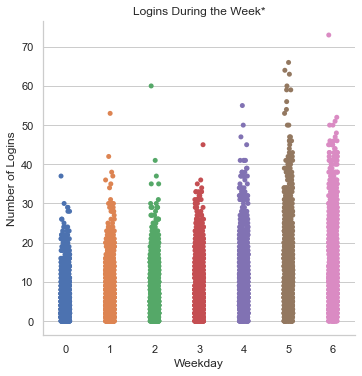

In [321]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(20,10))

b = sns.catplot(x="wkday", y="count", data=df_logins_wk)
b.set(title='Logins During the Week*')
b.set(xlabel='Weekday', ylabel='Number of Logins')

fig.text(.5, .0001, "*The #'s for Weekday start at 0 which represents Monday", ha='center')

plt.show()

**Sub-Macro Summary** | The rhythm appears to be a difference between:
   * Weekdays &
   * Weekends
     * Weekends seeing the highest amount of log-ins

<a id='micro'></a>**Micro** | We will now look at what time of the day these logins occur to ascertain if there is an uptick & reduction in logins at any specific time.

In [322]:
df_logins_stime = df_logins.copy()
df_logins_stime.reset_index()
df_logins_stime['time'] = pd.to_datetime(df_logins_stime['login_time']).dt.time
df_logins_stime['date'] = pd.to_datetime(df_logins_stime['login_time']).dt.date
# df_logins_stime.head()

In [323]:
df_logins_stime = df_logins_stime.groupby(["time",'date'])['count'].sum()
df_logins_stime = pd.DataFrame([df_logins_stime]).T
df_logins_stime.head()

count
time     date             
00:00:00 1970-01-02     15
         1970-01-03     15
         1970-01-04     15
         1970-01-05      6
         1970-01-06      5

In [324]:
df_logins_stime_rev = df_logins_stime.reset_index()

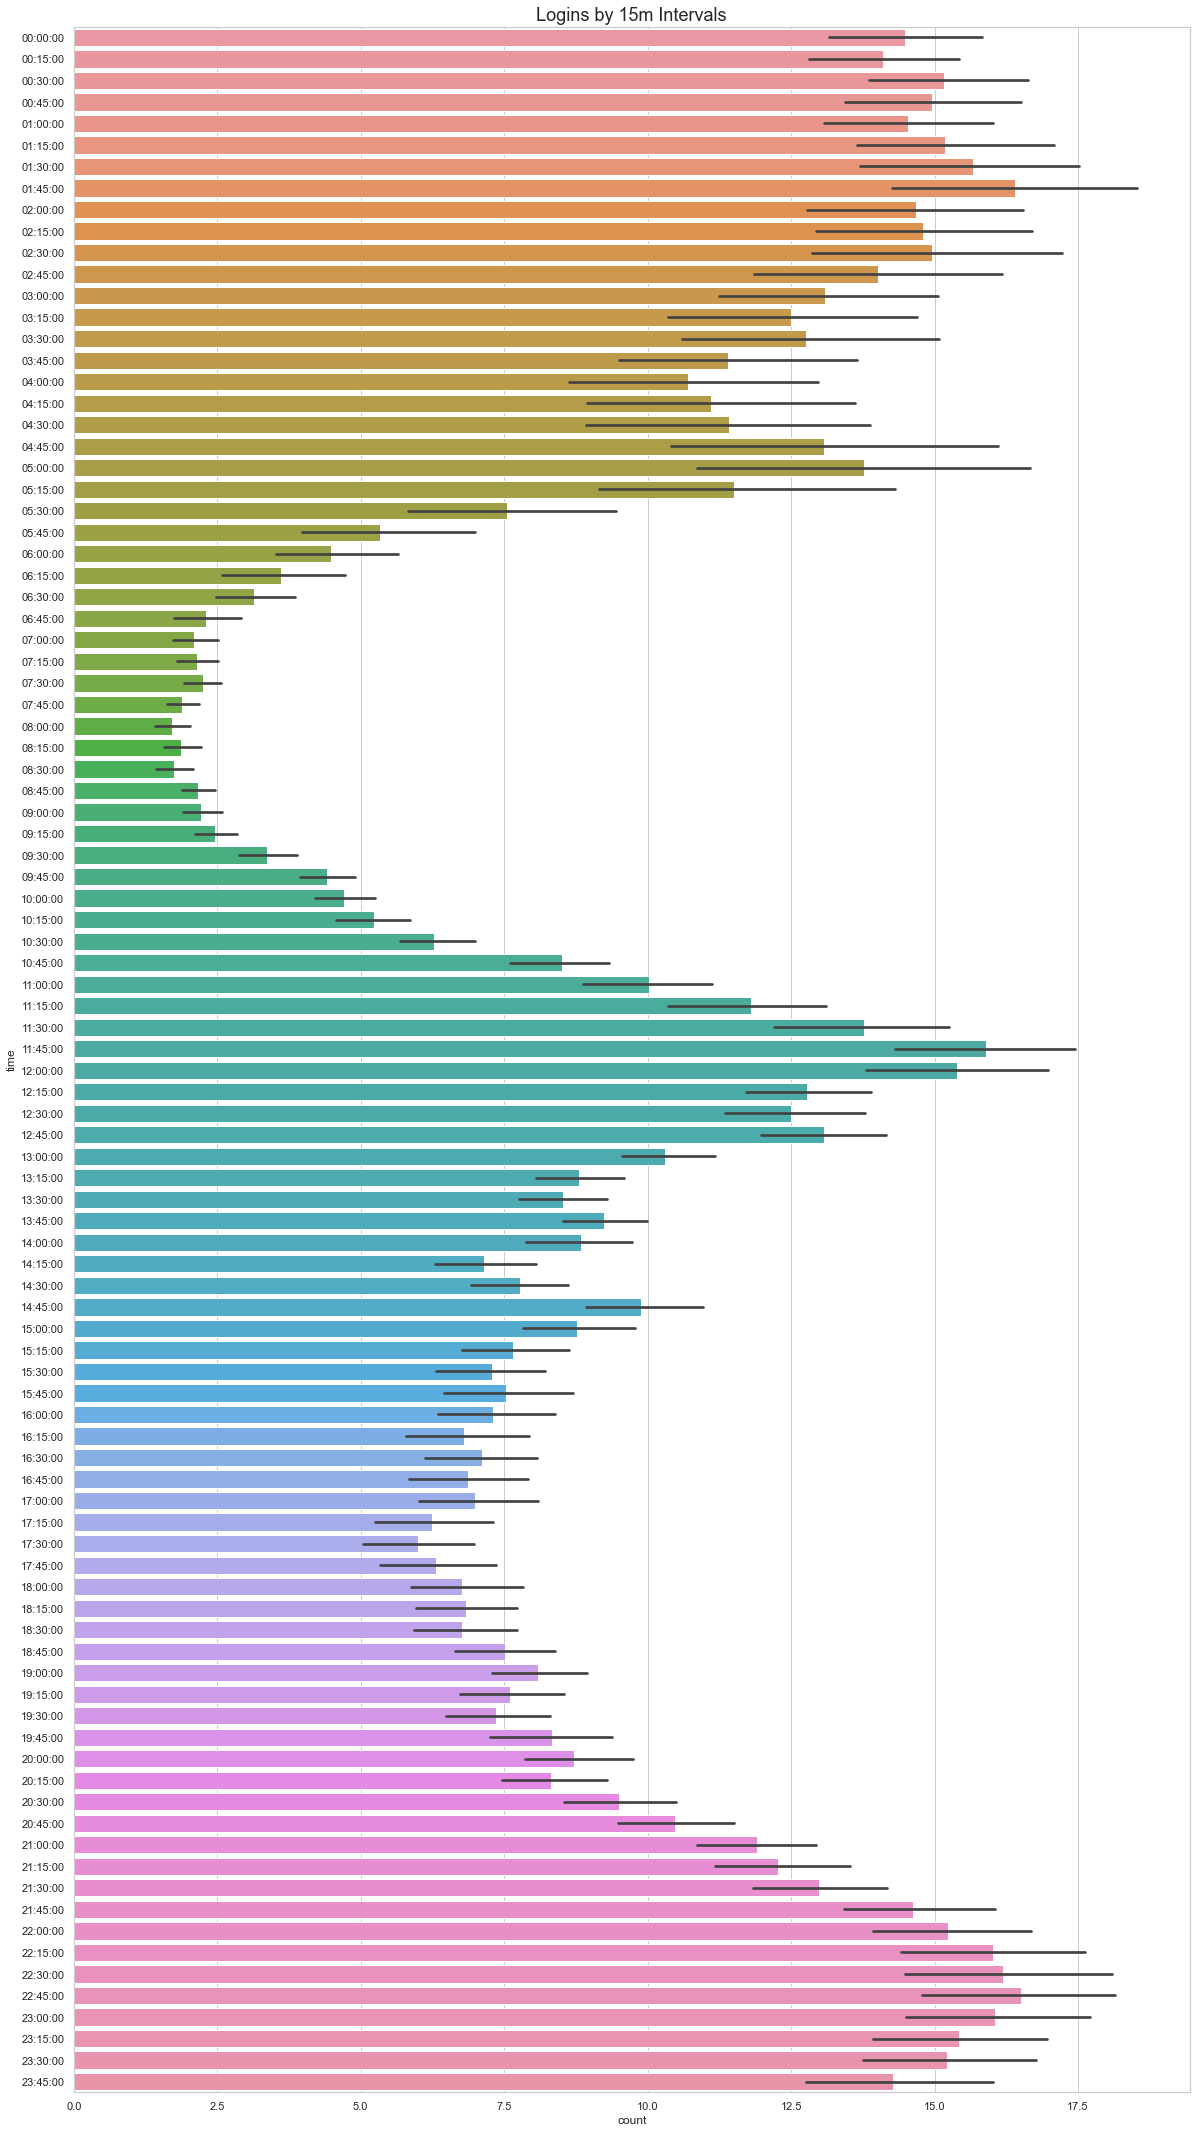

In [325]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(20,38))

sns.barplot(x="count", y="time", data=df_logins_stime_rev)
# a.set(title='Logins During the Week*')
# a.set(xlabel='Weekday', ylabel='Total Number of Logins')
plt.title('Logins by 15m Intervals', fontsize=18)
plt.show()

In [326]:
logins_stime_rev_gb = df_logins_stime_rev.groupby('time')['count'].sum()
logins_stime_rev_gb = pd.DataFrame([logins_stime_rev_gb]).T
logins_stime_rev_gb = logins_stime_rev_gb.reset_index()
# logins_stime_rev_gb

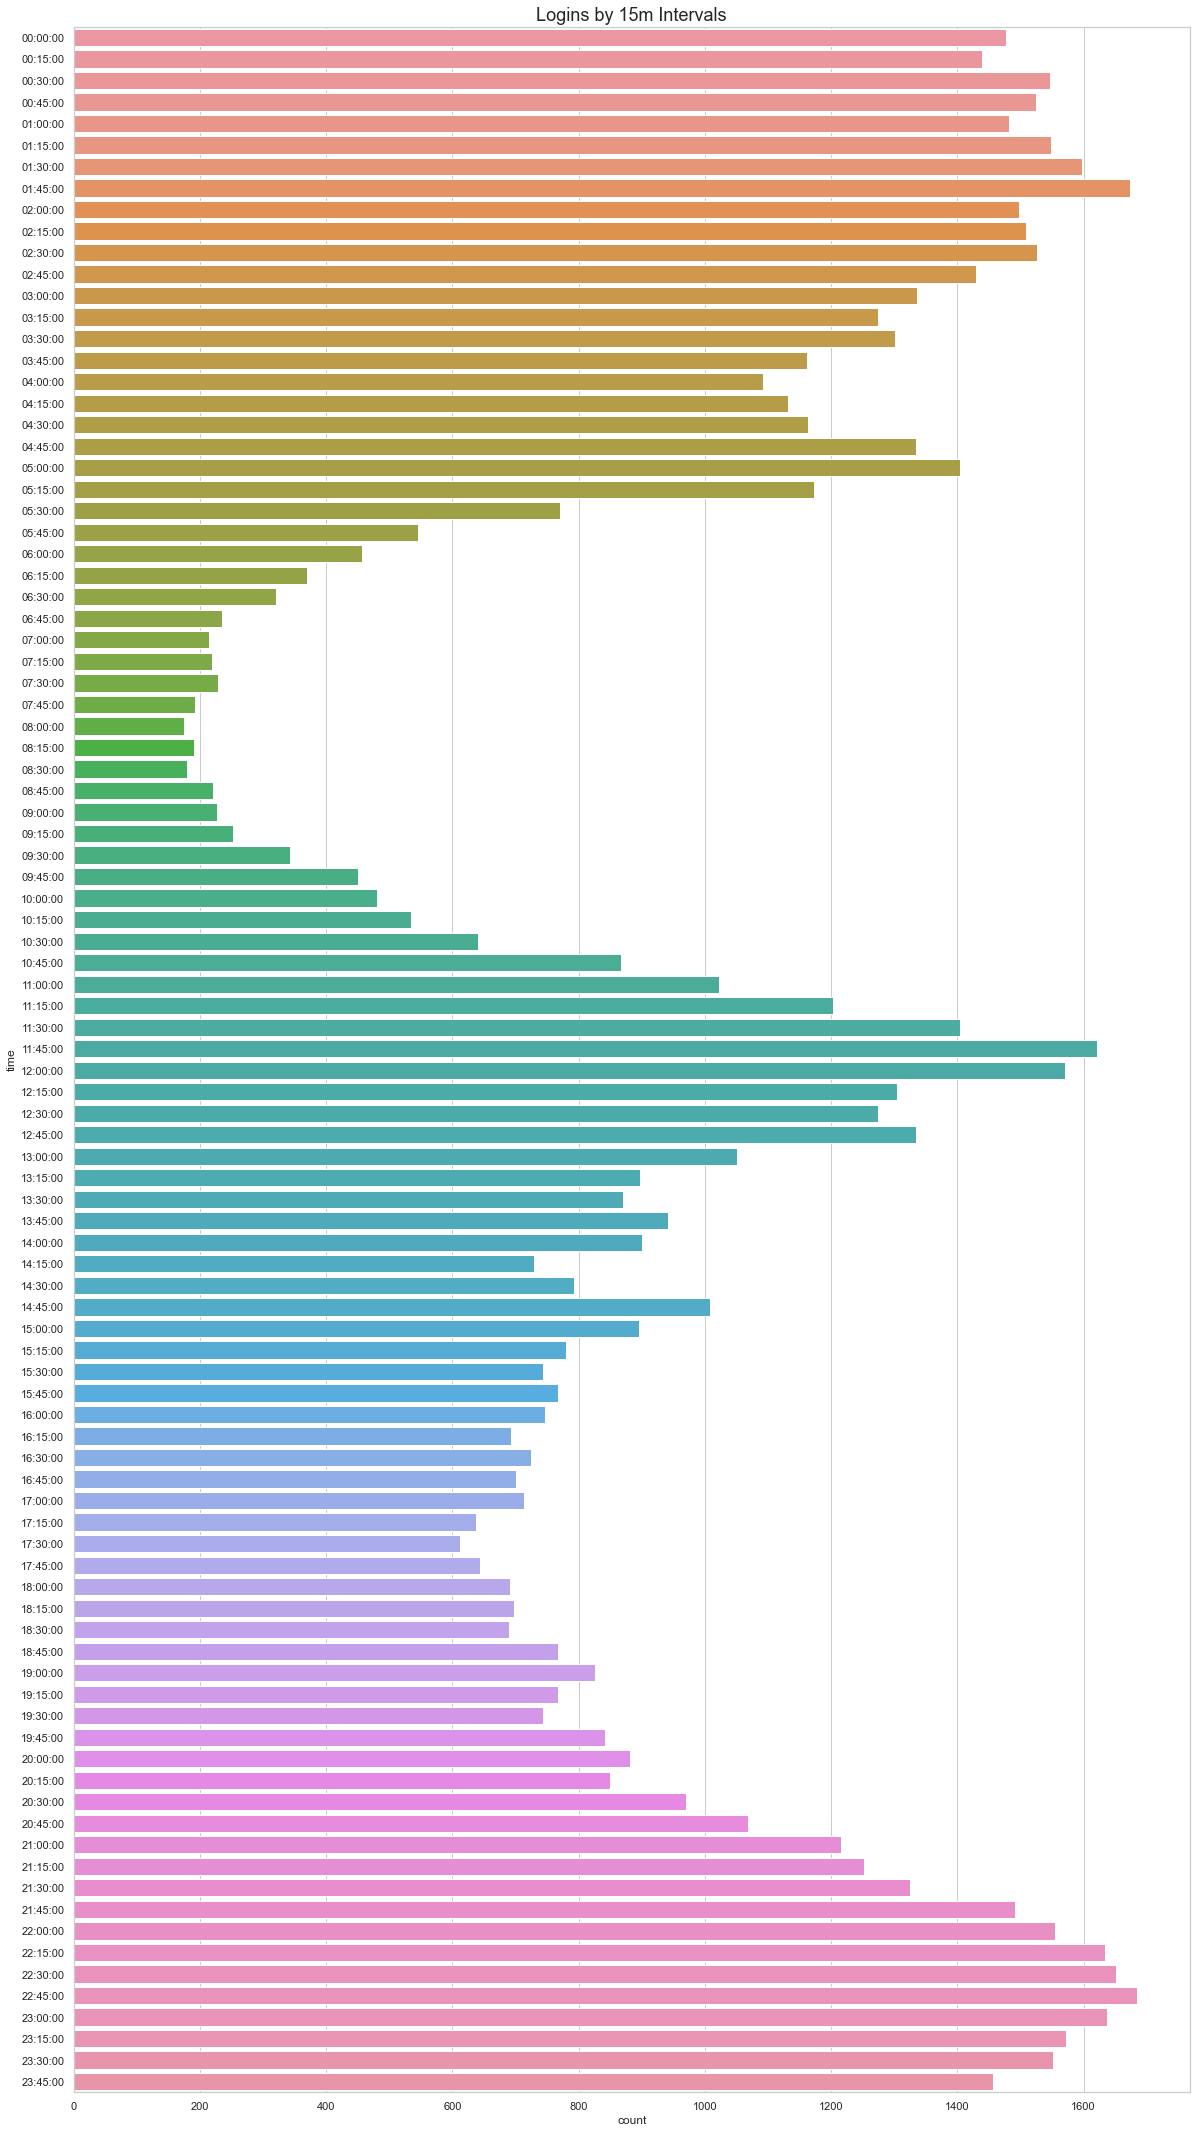

In [327]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(20,38))

sns.barplot(x="count", y="time", data=logins_stime_rev_gb)
# a.set(title='Logins During the Week*')
# a.set(xlabel='Weekday', ylabel='Total Number of Logins')
plt.title('Logins by 15m Intervals', fontsize=18)
plt.show()

It would be nice to subcategorize these into **'Tranches'**; we will take a look at the Descriptive Statistics for some initial guidance on this. **Short-term goal is for 5 Tranaches**.

In [328]:
logins_stime_rev_gb.describe()

,count
count,96.000000
mean,970.229167
std,455.485640
min,175.000000
25%,690.750000
50%,899.500000
75%,1404.000000
max,1684.000000


<AxesSubplot:xlabel='count', ylabel='Count'>

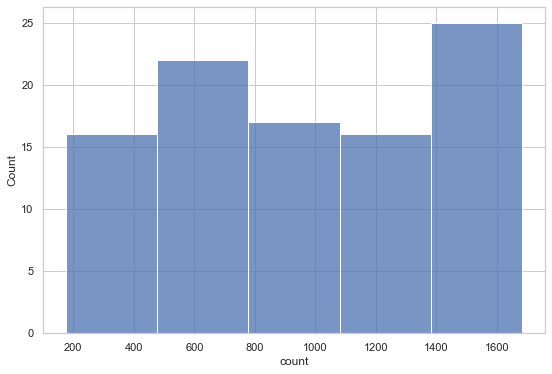

In [329]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(9,6))
sns.histplot(data=logins_stime_rev_gb, x="count",bins=5)

I don't believe that is fair to the data seen in the bar chart to achieve our Short-term goal; **we will manually select our Tranches below.**

In [330]:
def tranche(row):
    if row['count'] >= 1405:
        tranche_val = 'T1'
    elif row['count'] >= 1013:
        tranche_val = 'T2'
    elif row['count'] >= 610:
        tranche_val = 'T3'
    else:
        tranche_val = 'T4'
    
    return tranche_val

In [331]:
logins_stime_rev_gb['Tranche'] = logins_stime_rev_gb.apply(tranche, axis=1)
logins_stime_rev_gb = pd.DataFrame(logins_stime_rev_gb)
# logins_stime_rev_gb.head(2)
logins_stime_rev_gb.nunique()

time       96
count      91
Tranche     4
dtype: int64

In [332]:
labels = list(logins_stime_rev_gb['Tranche'].unique())
labels

['T1', 'T2', 'T3', 'T4']

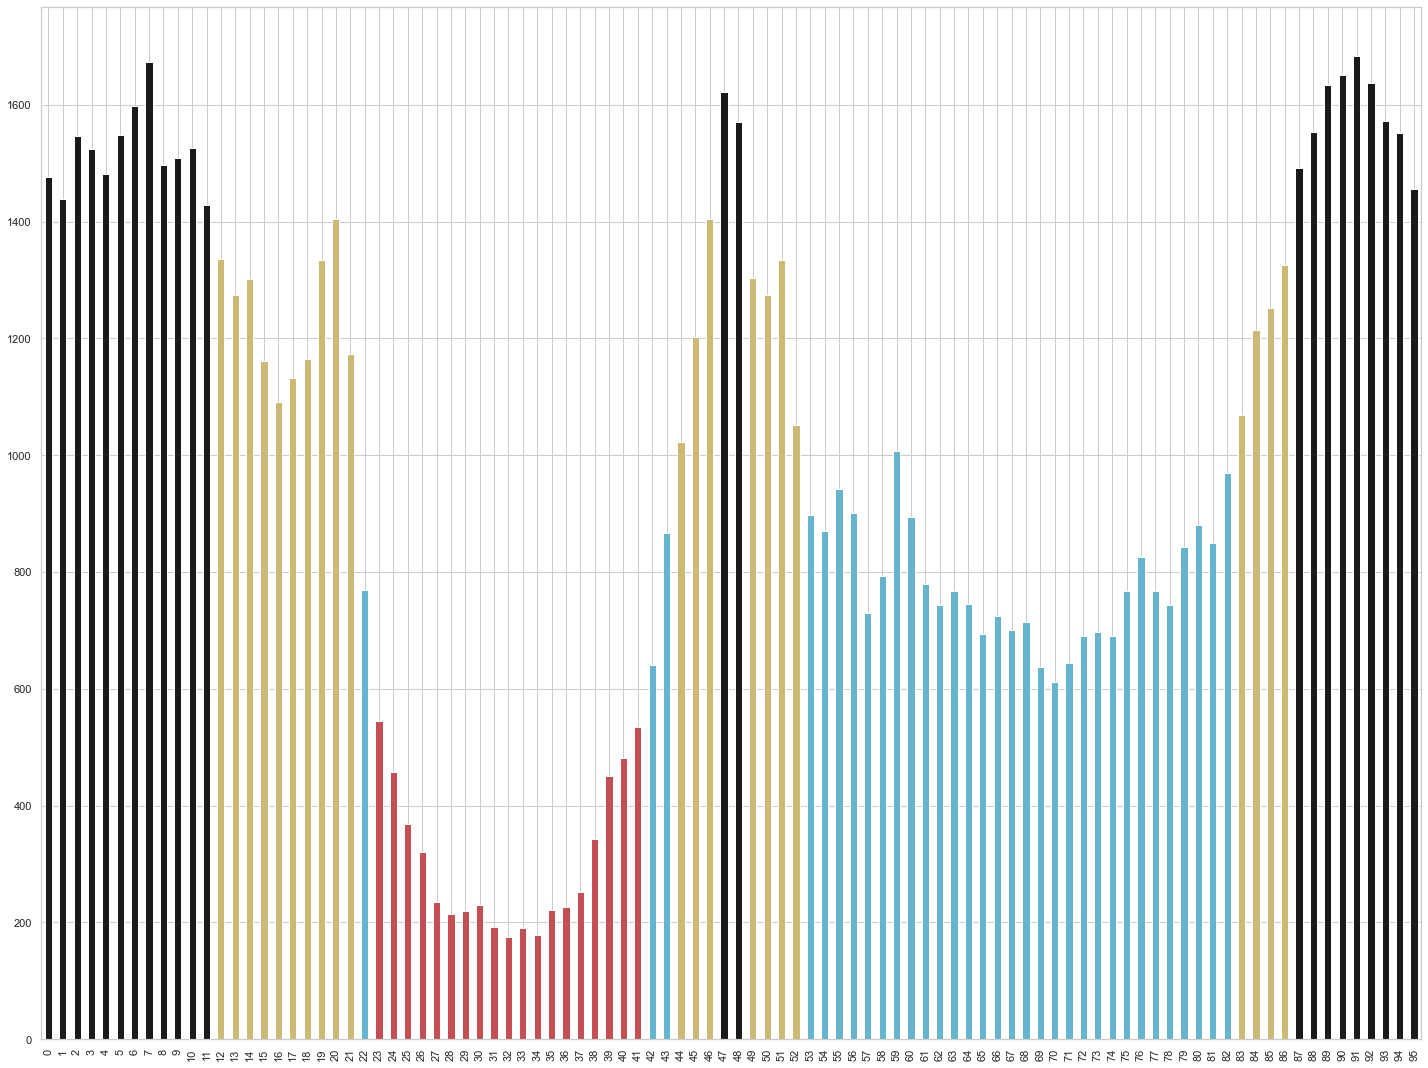

In [333]:
fig = plt.figure(figsize=(20,15))

colours = { 'T1': "k",'T2': "y",'T3': "c",'T4': "r"}
logins_stime_rev_gb['count'].plot(
    kind="bar", #you added an "h" here
    color=logins_stime_rev_gb['Tranche'].replace(colours)
)

plt.tight_layout()
plt.show()

**Micro Summary** | The rhythm appears to be a difference between:
   * **High** | Night & Very Early morning
     * ~ 21:45 PM to 2:45 AM ( a noticable uptick occurs ~11:45AM to 12AM )
       * **Possible Reason** | Going out with friends for beverages & requiring help getting home; the noticable uptick occurs around lunch as well
   * **Mid**  | Late Morning to Late Afternoon
     * ~10:45 AM to 21:30 PM 
       * **Possible Reason** | Normal working & living hours
   * **Low**  | Early Morning
     * ~ 5:30 AM to 10:30 AM
       * **Possible Reason** | Slept in from the night before; work typically starts at 9AM so these numbers appear odd
  

<a id='o_sum'></a>**Overall Summary** | The approach has yielded some interesting observations to help reach our goal; to reiterate, our goal is too:
   * **Best characterize the underlying patterns of the demand**
   
At the **Macro-level**, the most important finding was **a cyclical rhythm**. We also saw a potential drop in April but believe that may be outside the scope of this project & the goal. We then found, at the **Sub-Macro-level**, a notable **difference between Weekend & Weekday demand.** these findings were further investigated at the **Micro-level**, where we found notable **Tranches of High, Low & Mid-levels of demand.**

We will also highlight that there were **no identified data quality issues and we assume the data was provided by a reliable source**. The only outsiding items for **potentially further investigation** are as follows:
   * **Macro-level Demand Change** | A trend in rising demand was seen but with a sight drop in April
   * **Differentiating Daily Usage by Wkend & Wkday** | Differences in usage between the time of the day on a Weekday vs Weekend level:
     * This "may" help explain the start of the Mid-level usage at ~10:45AM given the work day usually starts at 9:00AM. Since we know of a comparatively higher usage during the weekends overall, Weekend usage may bring up the average then.


# Part 2 ‑ Experiment and metrics design<a id='p_two'></a>

I was presented that **Gotham and Metropolis have inverse usage rhythms during the Weekday & similar usage rhythms during the Weekend** notably:
   * **Weekday actvity**
     * Ultimate Gotham | Nightly Active
     * Ultimate Metropolis | Active during the day
   * **Weekend activity**
     * There is reasonable activity in both cities
       * <i>This would make sense given it's non working hours</i>

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

**We will now setup a `Problem Statement` for a project to answer the Ultimate managers proposition.**

**Criteria for success**<a id='success_c'></a>

**Question's** 
   * What would we choose as the key measure of success of this experiment in encouraging driver partners to serve both cities?
   * Why would we choose this metric?


**Answer |** Weekday engagement would be chosen as the key measure of success as there's comparatively less reason to believe that drivers will migrate to the other side of town, while using the tollbridge, when there's documented evidence of business traffic for them in their "backyard" during that time. 

This is also based on the belief that the data analytics built in Part 1 is seperate from Part 2. The decision outlined in the previous paragraph is based only the information provided at the start of Part 2.

**Practical Experiment**<a id='experiment'></a>

**Description** | The key details for the structure of the practical experiment used to compare the effectiveness of the proposed change in relation to the key measure of success can be defined in the **Question's below**:

   * How you will implement the experiment
   * What statistical test(s) you will conduct to verify the significance of the observation
   * How you would interpret the results and provide recommendations to the city operations team along with any caveats

**Answer |** To reiterate, the study is below: 
   * The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs

Given this, we would have to build out a t-test on the number of trips over the bridge. To see if the change is significant (+25%) we would first build out a Control Group. The Control Group would be similar to what was presented in Part 1 (for another city) in that we can confirm the following:
   * The information provided by the Ultimate managers of city operations for the two cities is correct

Once complete, we have a Control Group; i.e. something to compare the new policy of remunerating Toll Costs against. The period of time required for the construction of the Control Group is certainly up to city mgmt but idealy a 12 month period would mitigate against weather considerations. I did not see any mention of a period required for this project to be complete but if city mgmt requires less time then we would be required to explain for a potential bias in the output. 

Regardless of the time allowed to build the Control Group, we would build it & have the data to best understand trends & rhythms of:
   * Before the Toll Bridge reimbursement against 
   * The data after the Introduction of the New Policy 

The key metrics to determine if it was or was not successful would be new or increased revenue. This metric would be used as the key to determine the success of the policy; i.e. should the policy remain after implementation or discontinue it.

There are additional quantitative or qualitative metrics ("AQQM") that may be positive or negative such as:
   * Quantitative
     * Positive | Increased Merchant Revenue
     * Negative | Increased Crime
   * Qualitative
     * Positive | A larger sense of community
     * Negative | Anger towards "out of towners" crowding up their merchant spots

The AQQM's, however, are outside the scope of the project; only to be something to think about after the project. It "may" not hurt to measure that during the Control Group phase if it does not infridge on the project's time & resources.

# Part 3 ‑ Predictive modeling<a id='p_three'></a>

In this section, Ultimate is interested in predicting rider retention. To help explore this question, **Ultimate provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014**. The data was pulled several months later; **Ultimate considers a user retained if**
   * They were “active” (i.e. took a trip) in the preceding 30 days
   
**This data set will be used to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.**


We will first import.

In [334]:
# importing
df_udc = pd.read_json('./SB #26 Effective Interviewing for Data Scientists/Ultimate Technologies Inc. Take-Home Challenge/ultimate_data_challenge.json')
print('Finished')

Finished


**Cleaning**<a id='p_three_clean'></a> | Now imported, we will take a look & clean (if required).

In [335]:
# confirming it works
df_udc.head(1)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0


In [336]:
df_udc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [337]:
df_udc.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


**Data Description**

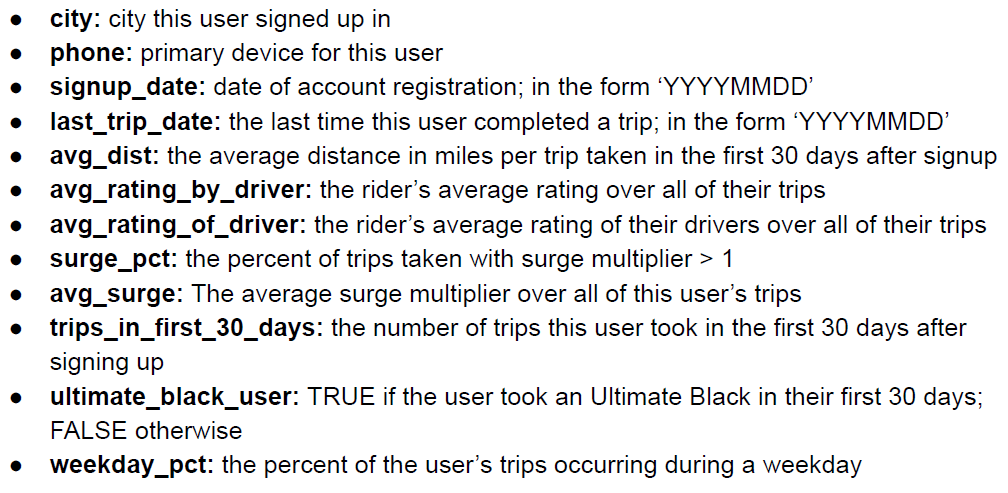

My **initial suggestions for adjustments** are that **the below should be converted to a datetime object**:
   * signup_date
   * last_trip_date



In [338]:
# first the signup_date
new_date = df_udc['signup_date'].copy()
new_date = new_date.str.split(expand=True)
new_date = new_date[0]
new_date = pd.to_datetime(new_date)
df_udc['signup_date'] = new_date

# second the last_trip_date
new_date2 = df_udc['last_trip_date'].copy()
new_date2 = new_date2.str.split(expand=True)
new_date2 = new_date2[0]
new_date2 = pd.to_datetime(new_date2)
df_udc['last_trip_date'] = new_date2

In [339]:
df_udc['signup_date'].dtype

dtype('<M8[ns]')

In [340]:
df_udc['last_trip_date'].dtype

dtype('<M8[ns]')

Great. There are **three (3) columns with null values** listed above. To reiterate they are `avg_rating_of_driver`, `phone` & `avg_rating_by_driver`.

Two of them, `avg_rating_of_driver` & `avg_rating_by_driver`, are a rating scale of the driver & passenger respectively. Let's see numerically how much the null values represent.

In [341]:
av_d = '{:,.1f}%'.format((((df_udc['avg_rating_by_driver'].count() / len(df_udc))-1)*100))
av_p = '{:,.1f}%'.format(((df_udc['avg_rating_of_driver'].count() / len(df_udc)-1)*100))

print('Looking at the percentages of missing data in the rating scales below:','\n','\n',
     av_p,'|','# of Null Values in Av. Rating of Driver by Passenger in Data Frame','\n',
     av_d,'|','# of Null Values in Av. Rating of Passenger by Driver in Data Frame')

Looking at the percentages of missing data in the rating scales below: 
 
 -16.2% | # of Null Values in Av. Rating of Driver by Passenger in Data Frame 
 -0.4% | # of Null Values in Av. Rating of Passenger by Driver in Data Frame


My initial thoughts on these are as follows:
   * The **Drivers null values are insignificant**; they may take pride in their work
   * The **Passenger's is fairly significant**; if there was a problem though I'm sure they would report it 
     * We will make note of this later to see if there's an insignificant amount of positive ratings
   * There is **no identicification classification data** to assign averages for either so 

**We will fill the missing values with averages.**

In [342]:
df_udc['avg_rating_by_driver'] = df_udc['avg_rating_by_driver'].fillna(df_udc['avg_rating_by_driver'].mean())
df_udc['avg_rating_of_driver'] = df_udc['avg_rating_of_driver'].fillna(df_udc['avg_rating_of_driver'].mean())
df_udc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

Great. Now the phone numbers.

In [343]:
av_phone = '{:,.1f}%'.format((((df_udc['phone'].count() / len(df_udc))-1)*100))
print('The average number of null values for phones is also insignificant with', av_phone, 'missing.')

The average number of null values for phones is also insignificant with -0.8% missing.


Taking a look at how the "non-null" values breakdown.

In [344]:
df_phone = df_udc['phone'].value_counts().index.tolist()
df_phone_vc = df_udc['phone'].value_counts()
share = '{:,.1f}%'.format((((df_phone_vc[0] / len(df_udc)))*100))
# share = df_phone_vc[0]
print(' There appears to only be two reported phones',df_udc['phone'].unique(),'\n','\n',
      'The most widely used phone herein is', df_phone[0], 'commanding', share, 'of the total reported share.','\n','\n',
     'This may be significant but the total number of missing values of all phones is',av_phone,'of the data set &','\n',
     'Thus, we wont get fancy, we will just backward fill all missing values.')

 There appears to only be two reported phones ['iPhone' 'Android' None] 
 
 The most widely used phone herein is iPhone commanding 69.2% of the total reported share. 
 
 This may be significant but the total number of missing values of all phones is -0.8% of the data set & 
 Thus, we wont get fancy, we will just backward fill all missing values.


In [345]:
df_udc['phone'].fillna(method='bfill', inplace=True)
df_udc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

**We now have a clean set** with:
   * No null values &
   * We agree with all the dtypes
   
**Ready to move on.**

**EDA**<a id='p_three_eda'></a>

**Data Description** Revisited

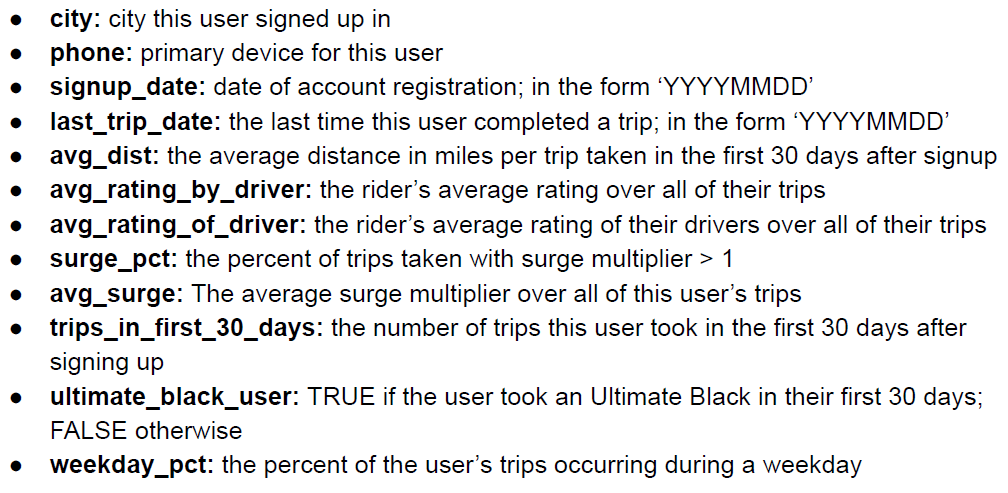

To reiterate, we cleaned the **data** ( **no null values** ) so **we will take a look above & below to mentally extrapolate as to what we may be able to see to help solve our problem; which is:**
   * City Mgmt for both cities have an experiment idea to encourage drivers to be available in both cities by reimbursing all toll costs.

In [346]:
df_udc.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


Taking a look at how much of the data frame is composed of users who actively used the service in the last 30 days. 

In [347]:
active_users = []
for i in range(len(df_udc)):
    sup = pd.Timestamp(df_udc['signup_date'][i])
    end = sup + pd.Timedelta('181D')
    active = end - pd.Timedelta('30D')
    if active <= pd.Timestamp(df_udc['last_trip_date'][i]) <= end:
        active_users.append([1])
    else:
        active_users.append([0])

df_udc['active_users'] = pd.DataFrame(active_users,columns=['active_users'])
act = df_udc['active_users'].value_counts()
av = round((df_udc['active_users'].sum()/len(df_udc)*100),2)
print( "{:,}%".format(av),'are active.')

24.4% are active.


In [348]:
df_udc['active_users_wrd'] = df_udc['active_users'].replace([0, 1], ['Inactive', 'Active'])

In [349]:
df_udc.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_users,active_users_wrd
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0,Inactive
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,Inactive
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,Inactive
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,Active
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,Inactive


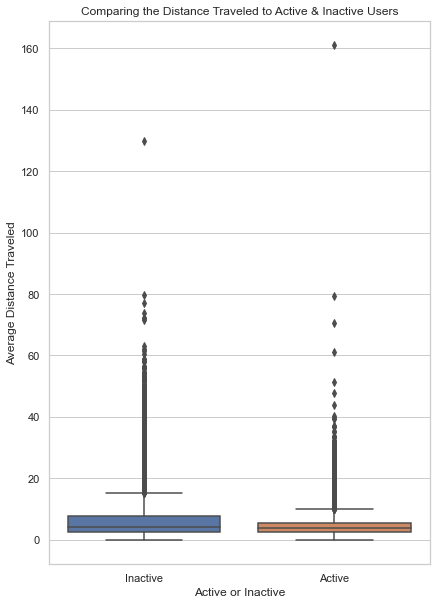

In [350]:
fig = plt.figure(figsize=(15,10))
plt.subplot(122)
ax = sns.boxplot(x="active_users_wrd", y="avg_dist", data=df_udc)
                #order=country_comp.sort_values('word_count',ascending=False).country
ax.set(xlabel='Active or Inactive', ylabel='Average Distance Traveled', title='Comparing the Distance Traveled to Active & Inactive Users')
plt.show()

Oddly enough, the longer the distance the less likely one would be active.

Let's see if Active or Inactive Users have differences in their ratings.

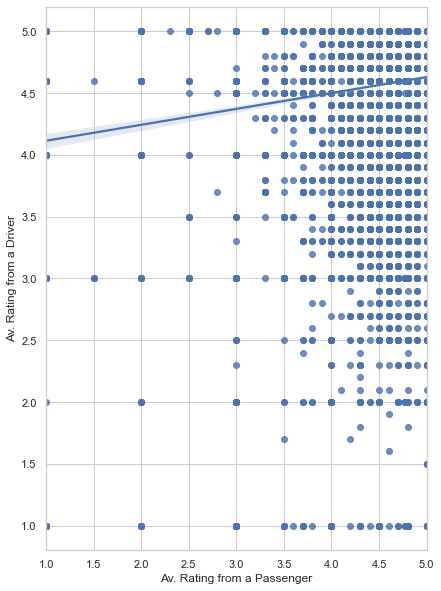

In [351]:
fig = plt.figure(figsize=(15,10))
# Setting up the Box Plot
plt.subplot(122)
ax = sns.regplot(y=df_udc['avg_rating_of_driver'], x=df_udc['avg_rating_by_driver'], fit_reg = True)
ax.set(xlabel='Av. Rating from a Passenger', ylabel='Av. Rating from a Driver')
plt.show()


There is no noteable correlation but I would believe a Standard Scaler may help.

**Breaking into Categories**<a id='cats'></a>

In [352]:
df_cat = df_udc.copy()

Looking into the categories, the cities are a prudent start.

In [399]:
# let's take a look at which cities are present
df_cat['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [402]:
c_active = pd.crosstab(index=df["active_users"], 
                            columns=df["city"],
                             margins=True)   # Include row and column totals

c_active.columns = ["Kings Landing", 'Astapor', 'Winterfell',"Total"]
c_active.index= ["Not Active","Active","Total"]

In [403]:
c_active

,Kings Landing,Astapor,Winterfell,Total
Not Active,13838,6099,17865,37802
Active,2696,4031,5471,12198
Total,16534,10130,23336,50000


In [417]:
# King's Landing
c_cl_act = '{:,.1f}%'.format((((c_active['Kings Landing'][1] / c_active.Total[1])*100)))
c_cl_t = '{:,.1f}%'.format((((c_active['Kings Landing'][2] / c_active.Total[2])*100)))

# Astapor
c_a_act = '{:,.1f}%'.format((((c_active['Astapor'][1] / c_active.Total[1])*100)))
c_a_t = '{:,.1f}%'.format((((c_active['Astapor'][2] / c_active.Total[2])*100)))

# Winterfell
c_w_act = '{:,.1f}%'.format((((c_active['Winterfell'][1] / c_active.Total[1])*100)))
c_w_t = '{:,.1f}%'.format((((c_active['Winterfell'][2] / c_active.Total[2])*100)))


In [439]:
print('Lookin at the results we can see the below:','\n','\n',
     'Kings Landing | '+c_cl_act+' of their population are active'
     ,'\n'+' Kings Landing | '+c_cl_t+' of the total Population','\n','\n',
     'Astapor       | '+c_a_act+' of their population are active'
     ,'\n'+' Astapor       | '+c_a_t+' of the total Population','\n','\n',
     'Winterfell    | '+c_w_act+' of their population are active'
     ,'\n'+' Winterfell    | '+c_w_t+' of the total Population')

Lookin at the results we can see the below: 
 
 Kings Landing | 22.1% of their population are active 
 Kings Landing | 33.1% of the total Population 
 
 Astapor       | 33.0% of their population are active 
 Astapor       | 20.3% of the total Population 
 
 Winterfell    | 44.9% of their population are active 
 Winterfell    | 46.7% of the total Population


Based on these results, Kings Landing may require some help. Winterfell appears to be holding pretty well.

Looking at Ultimate Black versus Active. To reiterate, the Ulimate Black is saying True or False if a User took an Ultimate Black in their first 30 days.

In [353]:
ul_b = pd.crosstab(index=df_cat["active_users"], 
                            columns=df_cat["ultimate_black_user"],margins=True)

ul_b.columns = ["Not_Ult_B","Ult_B","Total"]
ul_b.index= ["Not_Active","Active","Total"]

ul_b


,Not_Ult_B,Ult_B,Total
Not_Active,25204,12598,37802
Active,5942,6256,12198
Total,31146,18854,50000


In [354]:
ult_b_p = '{:,.1f}%'.format((((ul_b.Ult_B[1] / ul_b.Total[1])*100)))
ult_b_a_t = '{:,.1f}%'.format((((ul_b.Total[1] / ul_b.Total[2])*100)))

print(' It appears that Ultimate Black Users control '+ult_b_p+' of the Active Users','\n',
      'but in the end Active Users as a whole only contribute '+ult_b_a_t+' of the Total.',
      '\n','\n','Thus, people are unfortunately not active.'
     )

 It appears that Ultimate Black Users control 51.3% of the Active Users 
 but in the end Active Users as a whole only contribute 24.4% of the Total. 
 
 Thus, people are unfortunately not active.


Let's take a look at which phones they are using. That's a clean category breakdown & may present opportunities to clean up the app's for either iPhone and.or Android.

In [355]:
phone_review = pd.crosstab(index=df_cat["active_users"], 
                            columns=df_cat["phone"],
                             margins=True)

phone_review.columns = ["Android","iPhone","Total"]
phone_review.index= ["Not Active","Is Active","Total"]

phone_review

,Android,iPhone,Total
Not Active,13194,24608,37802
Is Active,1950,10248,12198
Total,15144,34856,50000


In [356]:
#iPhone
pr_iP_active = '{:,.1f}%'.format((((phone_review.iPhone[1] / phone_review.iPhone[2])*100)))
pr_iP_non_active = '{:,.1f}%'.format((((phone_review.iPhone[0] / phone_review.iPhone[2])*100)))
pr_iP_total = '{:,.1f}%'.format((((phone_review.iPhone[2] / phone_review.Total[2])*100)))

#Android
pr_an_active = '{:,.1f}%'.format((((phone_review.Android[1] / phone_review.Android[2])*100)))
pr_an_non_active = '{:,.1f}%'.format((((phone_review.Android[0] / phone_review.Android[2])*100)))
pr_an_total = '{:,.1f}%'.format((((phone_review.Android[2] / phone_review.Total[2])*100)))


In [357]:
print('Well we know that iPhone controls '+pr_iP_total+' of the market, there doesn\'t seem to be a notable disparity be inactivity:'
     '\n','\n'
     +pr_iP_non_active+' | iPhone users are inactive','\n'
     +pr_an_non_active+' | Android users are inactive','\n','\n',
     'We may be able to argue some attention to Android app but '+pr_iP_non_active+' inactivity on iPhone is also bad.')

Well we know that iPhone controls 69.7% of the market, there doesn't seem to be a notable disparity be inactivity:
 
70.6% | iPhone users are inactive 
87.1% | Android users are inactive 
 
 We may be able to argue some attention to Android app but 70.6% inactivity on iPhone is also bad.


**Modeling**<a id='p_three_model'></a>

In [358]:
label = preprocessing.LabelEncoder()
label.fit(['Astapor',"King's Landing",'Winterfell'])
LABEL = preprocessing.LabelEncoder()
LABEL.fit(['iPhone','Android'])
print('Complete')

Complete


In [359]:
df_mod.head(1)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_users,active_users_wrd
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0,Inactive


In [360]:
city_trans = le.transform(df_mod['city'])
phone_trans = LE.transform(df_mod['phone'])

In [361]:
df_cit = pd.DataFrame(city_trans,columns = ['city_new'])
df_p = pd.DataFrame(phone_trans, columns = ['phone_new'])
df = pd.concat([df_mod,df_cit,df_p],
               axis =1
              )

In [362]:
ult_b = []
for i in range(len(df)):
    if df['ultimate_black_user'][i] == True:
        ult_b.append([1]) 
    else:
        ult_b.append([0])
ult_b_mod = pd.DataFrame(ult_b,columns = ['ult_black'])

In [363]:
ult_b_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ult_black  50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB


In [364]:
df = pd.concat([df,ult_b_mod],axis =1)

In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  active_users            50000 non-null  int64 

In [366]:
y = df['active_users']
X = df[['avg_dist', 'avg_rating_by_driver','trips_in_first_30_days', 'city_new', 'phone_new','ult_black']]

In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.4,
                                                    random_state=42)

log = LogisticRegression()

log.fit(X_train,y_train)

y_pred = log.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[14804   338]
 [ 4298   560]]
              precision    recall  f1-score   support

           0       0.77      0.98      0.86     15142
           1       0.62      0.12      0.19      4858

    accuracy                           0.77     20000
   macro avg       0.70      0.55      0.53     20000
weighted avg       0.74      0.77      0.70     20000



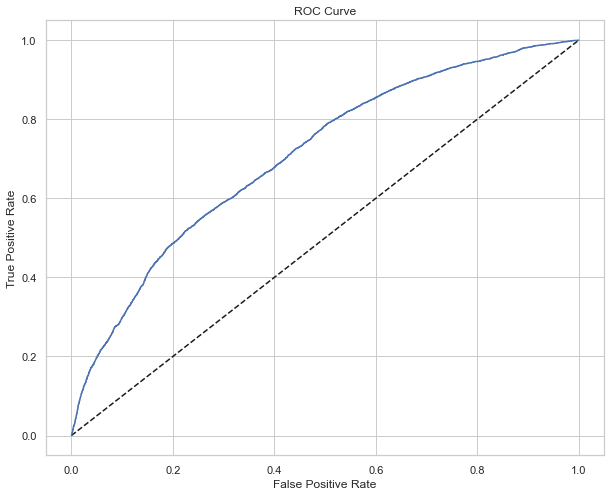

In [378]:
y_pred_prob = log.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [382]:
y_pred_prob = log.predict_proba(X_test)[:,1]
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

cv_auc = cross_val_score(log, X, y, cv = 5,scoring = 'roc_auc')
print("5-fold Cross-Validation AUC: {}".format(cv_auc))


AUC: 0.70774595663862
5-fold Cross-Validation AUC: [0.70146317 0.6969467  0.69274146 0.69990429 0.70782508]


In [383]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X,y)

# Print the tuned parameters and score
print("Logistic Regression Parameters | {}".format(logreg_cv.best_params_)) 
print("Best score  | {}".format(logreg_cv.best_score_))


Logistic Regression Parameters | {'C': 0.4393970560760795}
Best score  | 0.76726


In [391]:
seed = 8
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

model = XGBClassifier()
model.fit(X_train, y_train)


[15:21:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Text(0, 0.5, 'Feature Importance Score')

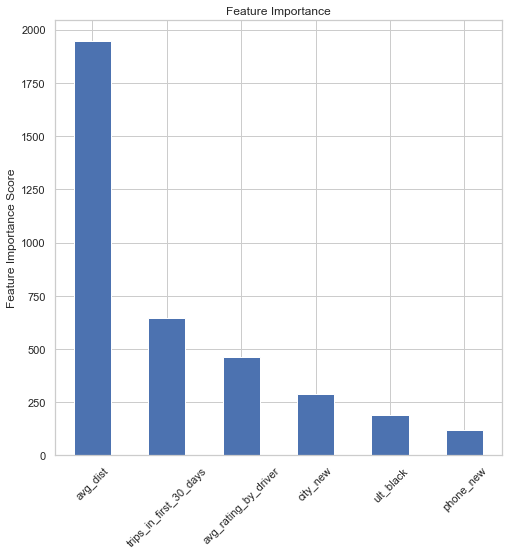

In [392]:
plt.figure(figsize=(8,8))
f_i = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
f_i.plot(kind='bar', title='Feature Importance')
plt.xticks(rotation=45)
plt.ylabel('Feature Importance Score')

In [393]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy | %.2f%%" % (accuracy * 100))


Accuracy | 77.42%


**Summary**<a id='p_three_summary'></a>

Our strategy for this project was to:
   * Ascertain the amount of active users
     * We discovered that ~24% are active
   * Recognize which data is best aligned with activity
     * Shorter trips resulted in higher activity
   * Identify which categorical data was correlated to activity
   * Build a model to predict active users
     * Logistic Regression was chosen as it's best placed for binary classification

Prior to modeling we reviewed the breakdown of `Cities`, `Ultimate Black` users & their `Phone` Type. We didn't see a clear distinction on activity for the latter two (2) but `Cities` showed that King's Landing may need some help.

Our modelling displayed an accuracy score of 77.42% with the `average distance` controlling it. Logistic Regression was chosen for our Model as it's better placed for binary classification. Our **ROC Score** was above the 50/50 line but nothing of notable distinction. One approach which was not undertaken but mentioned once, was scaling.

Better improvement in our modeling results may be witnessed if scaling is undertaken.


In [440]:
df_udc.to_csv('./SB #26 Effective Interviewing for Data Scientists/Ultimate Technologies Inc. Take-Home Challenge/df_udc.csv', index=False)
print('Finished')

Finished
